In [1]:
import normflows as nf
from normflows import flows
## Standard libraries
import os
import math
import time
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipykernel_1168697/3111489797.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Using device cuda:0


In [2]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN

In [3]:
from numpy.random import default_rng
rng = default_rng()


In [4]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''


prefix = "/hpc/group/vossenlab/mfm45/.dgl/"
dataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"
max_events = 1e5
split = 0.1
nlayers = 2
nmlp = 3
hdim = 64
nclasses, nfeatures, nfeatures_edge = get_graph_dataset_info(dataset=dataset, prefix=prefix)
dropout = 0.8
learn_eps = False
batch = 256
indices = None
nworkers = 0
npooling = "max"
gpooling = "max"
torch.manual_seed(0)

#select model
extractor = GIN(nlayers, nmlp, nfeatures,
            hdim, nclasses, dropout, learn_eps, npooling, gpooling).to(device)
extractor.load_state_dict(torch.load("logs/model_weights",map_location=device))

<All keys matched successfully>

In [5]:
split = 0.8
max_events = 100000
test_range = range(int(split*max_events),max_events)
test_dataset = GraphDataset(prefix+dataset)
test_dataset.load()
# test_dataset = Subset(test_dataset,range(int(min(len(test_dataset),max_events)*split)))
test_dataset = Subset(test_dataset,test_range)
test_bg = dgl.batch(test_dataset.dataset.graphs[test_dataset.indices.start:test_dataset.indices.stop])
test_bg = test_bg.to(device)
#grab latent space representation of graphs
test_latent_repr_intermediate = extractor.get_latent_repr(test_bg).detach().cpu()

/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [6]:
train_range = range(0, int(split*max_events))
train_dataset = GraphDataset(prefix+dataset)
train_dataset.load()
# train_dataset = Subset(train_dataset, range(int(min(len(test_dataset),max_events)*split),int(min(len(test_dataset),max_events))))
train_dataset = Subset(train_dataset, train_range)
train_dgl = dgl.batch(train_dataset.dataset.graphs[train_dataset.indices.start:train_dataset.indices.stop])
train_dgl = train_dgl.to(device)
#grab latentspace
train_latent_repr_intermediate = extractor.get_latent_repr(train_dgl).detach().cpu()

In [7]:
#add a 0 to the end of each point so that the dim is even and can split in half
add = torch.tensor([0])
train_latent_repr = torch.zeros(train_latent_repr_intermediate.size()[0],72)
test_latent_repr = torch.zeros(test_latent_repr_intermediate.size()[0],72)

for i in range(test_latent_repr_intermediate.size()[0]):
    test_latent_repr[i] = torch.cat((test_latent_repr_intermediate[i],add))
    test_latent_repr[i] = torch.cat((test_latent_repr_intermediate[i],add))

In [8]:
#new dims for training
train_num_events = train_latent_repr.size()[0]
train_latent_size = train_latent_repr.size()[1]

#calculate new dimensions for square version of latent space
test_num_events = test_latent_repr.size()[0]
test_latent_size = test_latent_repr.size()[1]

assert(train_latent_size == test_latent_size)

In [9]:
'''
Model Architecture
'''

num_layers = 32
hdim = 64
in_dim = 36
out_dim = 72
flows = []
for i in range(num_layers):
    param_map = nf.nets.MLP([in_dim,hdim,hdim,out_dim],init_zeros=True)
    #add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    #swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
distribution = nf.distributions.DiagGaussian(train_latent_size)
affine_coupling_block_model = nf.NormalizingFlow(distribution, flows)
model = affine_coupling_block_model.to(device)

In [10]:
max_iter = 1000
num_samples = 500
show_iter = 500

In [11]:
# model = affine_coupling_block_model
data = train_latent_repr
loss_hist = np.array([])
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
with tqdm(total=max_iter, position=0, leave=True) as pbar:
    for it in tqdm(range(max_iter), position = 0, leave=True):
        optimizer.zero_grad()
        #randomly sample the latent space
        indices = rng.integers(low=0, high=train_num_events, size=num_samples)
        samples = torch.zeros(num_samples,data.size()[1])
        for index in range(len(indices)):
            samples[index] = data[indices[index]]
#         print(samples)
        samples = samples.to(device)
        loss = abs(model.forward_kld(samples))
#         print(loss)
        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        # Log loss
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
        # Plot learned distribution
        if (it + 1) % show_iter == 0:
            model.eval()
            model.train()

# Plot loss

  0%|          | 0/1000 [00:55<?, ?it/s]


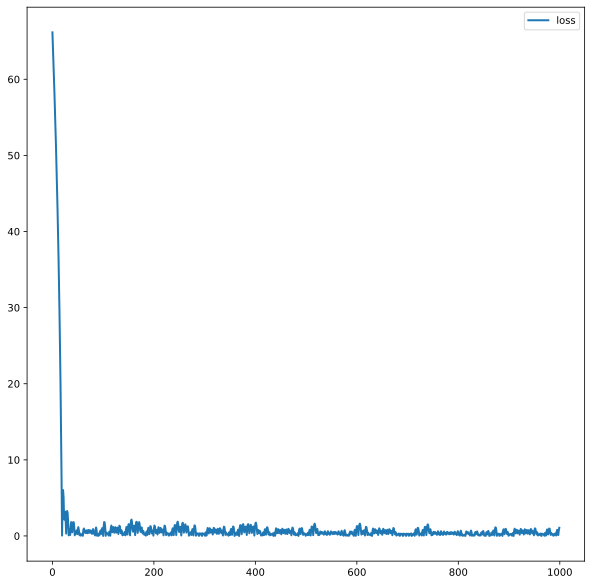

In [12]:
fig = plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()
fig.savefig("loss_block_model.jpeg")

In [13]:
#testing

torch.manual_seed(42)
model.eval()
max_iter = 20
num_samples = 500
test_loss = 0
new_loss = 0
counted_batches = 0
with torch.no_grad():
    for it in tqdm(range(max_iter), position = 0, leave=True):
        indices = rng.integers(low=0, high=test_num_events, size=num_samples)
        test_samples = torch.empty(num_samples,test_latent_size)
        for index in range(len(indices)):
            test_samples[index] = test_latent_repr[indices[index]]
        test_samples = test_samples.to(device)
        new_loss = model.forward_kld(test_samples)
        if(not math.isnan(new_loss)):
#             print(f"new_loss: {new_loss}")
            test_loss += new_loss
            counted_batches += 1
    print(f"average loss: {test_loss/counted_batches}")

100%|██████████| 20/20 [00:00<00:00, 56.52it/s]


ZeroDivisionError: division by zero

In [ ]:
new_hist = []
for i in range(loss_hist.size):
    if not loss_hist[i] > 150:
        new_hist.append(loss_hist[i])

In [ ]:
len(new_hist)

In [ ]:
with torch.no_grad():
    x = model.sample(10)

In [ ]:
x = x.detach.to(cpu)


In [ ]:
target = nf.distributions.ImagePrior(1 - plt.imread('../normalizing-flows/examples/kirby.jpeg')[:, :, 0])

In [ ]:
x = target.sample(100).double()

In [ ]:
def sample(num_steps, latent, num_samples, train_num_events, train_latent_size):
    z_ = torch.rand((2, 1))
    ind = (z_ * (train_latent_size - 1)).long()
    prob = torch.rand(num_steps)
    intensity = latent[ind[:,0]]
    accept = intensity > prob
    new_z = z_[accept, :]
    
    
    
    indices = rng.integers(low=0, high=train_num_events, size=num_samples)
    samples = torch.empty(num_samples,train_latent_size)
    for index in range(len(indices)):
        samples[index] = train_latent_repr[indices[index]]

In [ ]:
for i in range(20):
    plot.plot(train_latent_repr[i],'o')
plot.show()

In [ ]:
for i in range(20):
    plot.plot(samples[i].detach().numpy(),'o')
plot.show()